# Week6 Assignments
You'll gain some hands-on experience with monitoring your model using Prometheus and Evidently in this week's assignments.

**Guidelines of submitting assignments**:
- In the first assignment, you'll need to write some configurations in a YAML file, so please include the YAML file in your submission.  
- For every remaining assignment, a code skeleton is provided. Please put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments. 
- Some assignments also require you to capture screenshots in order to earn points. Please put all your screenshots into a single PDF file. For each screenshot, please clearly indicate which assignment it corresponds to in your PDF file. 
- When preparing your submission, be sure to include your assignment notebook with code cell outputs. It's important that these outputs are up-to-date and reflect the latest state of your code, as your grades may depend on them. Additionally, please include the PDF file that contains your screenshots in your submission. 

In [1]:
# Install packages
# mlserver and simplejson are used to encode the requests to be sent to the inference service.
# We downgrade mlserver (1.3.5 was used in week4 assignments) because 1.3.5 is not compatible with the evidently version we use.
%pip install mlserver==1.2.1 simplejson~=3.19.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tritonclient
    Found existing installation: tritonclient 2.18.0
    Uninstalling tritonclient-2.18.0:
      Successfully uninstalled tritonclient-2.18.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from collections import namedtuple
from pathlib import Path
import os
import requests
from lightgbm import LGBMRegressor
from mlserver.codecs import PandasCodec
from utils import send_requests, init_evidently_project
from IPython.display import display
from datetime import datetime
from typing import NamedTuple, Dict, Any, Callable, List
from unittest.mock import create_autospec
import webbrowser

from minio import Minio

import mlflow
from mlflow import MlflowClient

from evidently import ColumnMapping
from evidently.report import Report
from evidently.test_suite import TestSuite
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, RegressionPreset
from evidently.tests import TestValueMAE
from evidently.ui.workspace import Workspace
from evidently.ui.remote import RemoteWorkspace

import kfp
import kfp.dsl as dsl
from kfp.aws import use_aws_secret
from kfp.v2.dsl import (
    component,
    Input,
    Output,
    Dataset
)

import warnings
warnings.filterwarnings('ignore')

In [2]:
WORKING_DIR = Path.cwd()

# mlflow configuration
MLFLOW_S3_ENDPOINT_URL = "http://mlflow-minio.local"
MLFLOW_TRACKING_URI = "http://mlflow-server.local"
AWS_ACCESS_KEY_ID = "minioadmin"
AWS_SECRET_ACCESS_KEY = "minioadmin"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = MLFLOW_S3_ENDPOINT_URL
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

# Directory where model inputs(features received on production) and outputs(predictions) are saved
INPUTS_OUTPUTS_LOCAL_DIR_NAME = "inputs_outputs"

# Directory where ground truth is saved
GROUND_TRUTH_LOCAL_DIR_NAME = "ground_truth"

# Directory where the feature-engineered data (data preprocessed by the etl function from the second week) is saved
FEATURE_STORE_DIR_NAME = "feature_store"


## Preparation before starting the assignments
Let's begin by training a model and deploying it to KServe. This model is trained using the house price data that we used in Week2 assignments. The task of the model is to predict the price of a house given the house's information such as building year and living area.

In [3]:
mlflow_experiment_name = "week6-lgbm-house-price"
registered_model_name = "Week6LgbmHousePrice"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(mlflow_experiment_name)

<Experiment: artifact_location='s3://mlflow/10', creation_time=1701988906315, experiment_id='10', last_update_time=1701988906315, lifecycle_stage='active', name='week6-lgbm-house-price', tags={}>

The raw training data can be found from "raw_data/reference/train" directory. The training data has been feature-engineered using the `etl` function from the second week and are split into a feature file (0_0_X.parquet) and a target file (0_0_y.csv) in the "feature_store" directory. 

In [4]:
# Prepare training data
train_x = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / "0_0_X.parquet")
train_y = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / "0_0_y.csv")

# model hyperparameters (hyperparameter optimization was performed)
params = {
    "colsample_bytree" : 0.7,
    "learning_rate" : 0.075,
    "max_depth" : 50, 
    "min_child_samples" : 5,
    "min_split_gain" : 20.0,
    "n_estimators" : 1000,
    "num_leaves" : 100,
    "reg_lambda" : 50.0,
    "subsample" : 0.1,
    "random_state": 42
}

# Train a model and upload it to MLflow
model = LGBMRegressor(**params)

with mlflow.start_run() as run:
    mlflow_run_id = run.info.run_id
    model.fit(train_x, train_y)

    for key, val in params.items():
        mlflow.log_param(key, val)

    model_name = "lgbm-house"
    mlflow.lightgbm.log_model(
        lgb_model=model,
        artifact_path=model_name,
        registered_model_name=registered_model_name
    )
    model_s3_uri = mlflow.get_artifact_uri(artifact_path=model_name)
    print("The S3 URI of the registered model:", model_s3_uri)

Registered model 'Week6LgbmHousePrice' already exists. Creating a new version of this model...
2023/12/11 21:51:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Week6LgbmHousePrice, version 3
Created version '3' of model 'Week6LgbmHousePrice'.


The S3 URI of the registered model: s3://mlflow/10/8885edfb65ff419c80b5289a950ddfa5/artifacts/lgbm-house


In the final output line, you should see the model version created from the MLflow Run:
```text
Created version <your-model-version> of model 'Week6LgbmHousePrice'
```
Let's assign the model version to the `model_version` variable.

In [5]:
model_version = "1" # Replace this with your own model version, notice that the model_version is a string

You'll also see the S3 URI of your uploaded model printed . Let't then deploy the model to KServe. Before running the next cell, replace the `storageUri` in [manifests/house-price.yaml](./manifests/house-price.yaml) with your own S3 URI.

In [7]:
# Deploy an inference service named "house-price"
!kubectl apply -f manifests/house-price.yaml

inferenceservice.serving.kserve.io/house-price created


Expected output:
```text
inferenceservice.serving.kserve.io/house-price created
```

In [6]:
# Check if the "house-price" inference service is ready
!kubectl -n kserve-inference get isvc house-price

NAME          URL                                               READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION                   AGE
house-price   http://house-price.kserve-inference.example.com   True           100                              house-price-predictor-default-00001   3d21h


Expected output:
```text
NAME          URL                                               READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION                   AGE
house-price   http://house-price.kserve-inference.example.com   True           100                              house-price-predictor-default-00001   55s
```

In [7]:
# Then make sure there's a running pod for the "house-price" inference service
!kubectl -n kserve-inference get pods -l serving.kserve.io/inferenceservice=house-price

NAME                                                             READY   STATUS    RESTARTS   AGE
house-price-predictor-default-00001-deployment-bd4b9fcb9-lc452   2/2     Running   0          3d21h


Expected output:
```text
NAME                                                              READY   STATUS    RESTARTS   AGE
house-price-predictor-default-00001-deployment-748bc8bc67-r7p46   2/2     Running   0          68s
```

MLflow can be used to manage the lifecycle of models. We can transition a registered model to one of the stages: Staging, Production or Archived. Since we just deployed a model, let's change its stage to "Production".  

In [9]:
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

# Transition the stage of other model versions whose stage is "Production" to None
# This way we ensure there is only one model on the "Production" stage at any given time
for mv in client.search_model_versions(f"name='{registered_model_name}'"):
    if mv.current_stage != "Production":
        continue
    client.transition_model_version_stage(
        name=registered_model_name, version=mv.version, stage="None"
    )

client.transition_model_version_stage(
    name=registered_model_name, version=model_version, stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1701988926274, current_stage='Production', description='', last_updated_timestamp=1702139155343, name='Week6LgbmHousePrice', run_id='261767dbdb27409783912bf713700607', run_link='', source='s3://mlflow/10/261767dbdb27409783912bf713700607/artifacts/lgbm-house', status='READY', status_message='', tags={}, user_id='', version='1'>

If you go to [http://mlflow-server.local](http://mlflow-server.local), you should also see the model stage is "Production" on the MLflow UI. Make sure the model version is the same one as your `model_version` variable. 

<img src="./images/mlflow-prod-model.png" width="800" />

## Assignment 1: Monitoring 4xx responses of your inference service (2 points)
In this assignment, your task is to add a Prometheus alerting rule so that Prometheus will trigger an alert when your inference service gives too many client error responses (i.e., responses whose HTTP status code is 4xx). 

(If HTTP status codes are new to you, more information can be found [here](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes).)

You need to add an alerting rule to [manifests/prometheus-config-patch.yaml](./manifests/prometheus-config-patch.yaml) that **immediately** triggers an alert when your "house-price" inference service running in the "kserve-inference" namespace gives more than **ten** 4xx error responses in the **past one minute**. 

Please add your alerting rule between the commands "### START ALERTING RULE" and "### END ALERTING RULE". **Please include the file "prometheus-config-patch.yaml" in your submission.**

Hints:
- An essential part in configuring an alerting rule is to decide which PromQL query to use. It may be easier if you first test your query in the Prometheus UI [http://prometheus-server.local](http://prometheus-server.local) before writing your alerting rule to the configuration file. You can use the following code cell to send some invalid requests to your inference service, and then go to the Prometheus UI to test if your query can retrieve a reasonable value. 
- You may find the `revision_app_request_count` metric useful (introduced in the tutorial). You can then use the labels `namespace_name`, `isvc_name`, `response_code_class` to only include the responses you want to monitor. 
- You may also find the PromQL function [increase()](https://prometheus.io/docs/prometheus/latest/querying/functions/#increase) useful. 

In [48]:
# Let's pretend your downstream application is somehow broken and starts sending invalid requests to the inference service. 
# Inside each request, the input data is in a wrong format so the inference service will return responses with
# 422 (unprocessable entity) HTTP status code
send_requests(model_name="house-price", input=[None for _ in range(16)], count=20)

1 requests have been sent
2 requests have been sent
3 requests have been sent
4 requests have been sent
5 requests have been sent
6 requests have been sent
7 requests have been sent
8 requests have been sent
9 requests have been sent
10 requests have been sent
11 requests have been sent
12 requests have been sent
13 requests have been sent
14 requests have been sent
15 requests have been sent
16 requests have been sent
17 requests have been sent
18 requests have been sent
19 requests have been sent
20 requests have been sent


In [49]:
# Update the Prometheus configuration by patching your alerting rule to the ConfigMap consumed by the Prometheus pod
!kubectl -n monitoring patch configmap prometheus-server-conf --patch-file manifests/prometheus-config-patch.yaml

configmap/prometheus-server-conf patched


In [50]:
# Delete the old Prometheus pod so a new one that consumes the updated ConfigMap will be recreated automatically
!kubectl -n monitoring delete pod -l app=prometheus-server

pod "prometheus-deployment-7b898cb9d8-6rtsv" deleted


In [52]:
# Check if the new Prometheus pod is ready
!kubectl -n monitoring get pod -l app=prometheus-server

NAME                                     READY   STATUS    RESTARTS   AGE
prometheus-deployment-7b898cb9d8-8tzzb   1/1     Running   0          6s


Expected output:
```text
NAME                                     READY   STATUS    RESTARTS   AGE
prometheus-deployment-7b898cb9d8-g8wd2   1/1     Running   0          6s
```
The "AGE" should be relatively small since this pod should be created after you deleted the old one. 

In [53]:
# Send invalid requests again and you should see an alert of too many 4xx responses has been triggered
send_requests(model_name="house-price", input=[None for _ in range(16)], count=20)

1 requests have been sent
2 requests have been sent
3 requests have been sent
4 requests have been sent
5 requests have been sent
6 requests have been sent
7 requests have been sent
8 requests have been sent
9 requests have been sent
10 requests have been sent
11 requests have been sent
12 requests have been sent
13 requests have been sent
14 requests have been sent
15 requests have been sent
16 requests have been sent
17 requests have been sent
18 requests have been sent
19 requests have been sent
20 requests have been sent


### Screenshots for Assignment 1
Now you can go to [http://prometheus-server.local/alerts](http://prometheus-server.local/alerts) and see if the alert of too many 4xx responses is triggered.

**Please make a screenshot of the triggered alert and put it in your PDF file.** Please extend the alert field so your PromQL query is shown in the screenshot. Note the example is about another alert, it's just used to show you what should be included in the screenshot. 

<details>
    <summary>Example</summary>
    <img src="./images/alert-example.png" width=1000/>
</details>

## Assignment 2: Model-level monitoring with Evidently (4 points)
In this assignment, you'll use Evidently to monitor your model that predicts houce price. The model will be monitored on a quarter basis. 

### 2a) Prepare reference data
Let's start by preparing the reference data. Please complete the `prep_ref` function that performs the following tasks:
1. Concatenating a given feature DataFrame (denoted as `x` in the function) and a target DataFrame (denoted as `y` in the function) into a single DataFrame. The concatenation should be performed horizontally (side by side). You can assume that the feature and target DataFrames are aligned (for $i^{th}$ row of the feature DataFrame, the corresponding target is also at $i^{th}$ row of the target DataFrame).
1. Adding a new column to the concatenated DataFrame named "prediction". The values in this column are generated by calling the predict method (`model.predict()`) of the provided model on `x`. Simply speaking, the function adds a column of predicted values to the DataFrame.

Finally, the function should return the concatenated DataFrame with the "prediction" column added. 

**Hint**: You may find the [pandas.DataFrame.concat](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.concat.html) function useful. 

In [41]:
def prep_ref(x: pd.DataFrame, y: pd.DataFrame, model: LGBMRegressor|mlflow.pyfunc.PyFuncModel) -> pd.DataFrame:
    """
    Prepare a reference data by combining features, targets, and the predictions made by the model
    Args:
        x: Feature DataFrame
        y: Target DataFrame
        model: Used to make predictions on x
    Returns:
        Reference data (features+targets+predictions)
    """
    ### START CODE HERE
    ref_data = pd.concat([x, y], axis=1)
    ref_data["prediction"] = model.predict(x)
    
    return ref_data
    
    ### END CODE HERE

Let's test if your `prep_ref` function works correctly by preparing a reference dataset used in this assignment. We will use model's testing data as the reference data. 

In [42]:
model_s3_uri = "s3://mlflow/10/261767dbdb27409783912bf713700607/artifacts/lgbm-house" # This should be the same as the modelUri in your manifests/house-price.yaml

uploaded_model = mlflow.pyfunc.load_model(model_uri=model_s3_uri)

# read features and targets of the testing data
# We generated "1_0_X.parquet" and "1_0_y.csv" in advance by pre-processing the raw data in raw_data/reference/test using the etl function from the second week
test_x = pd.read_parquet(WORKING_DIR/FEATURE_STORE_DIR_NAME/"1_0_X.parquet")
test_y = pd.read_csv(WORKING_DIR/FEATURE_STORE_DIR_NAME/"1_0_y.csv", index_col=False)

current_ref_df = prep_ref(x=test_x, y=test_y, model=uploaded_model)
display(current_ref_df.head())
print(f"Reference DataFrame should have the following {current_ref_df.shape[1]} columns: {current_ref_df.columns}")

2023/12/11 21:58:11 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


,yr_built,bedrooms,postcode,area,bathrooms,condition,grade,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,year,price,prediction
0,1970.0,3.0,468060.054400,460458.275887,1.75,4,7.0,1590.0,20065.0,60.0,1675.0,17597.0,0.0,0.0,10.90,2009,300400.0,341136.698488
1,1940.0,4.0,600905.249689,600905.249689,2.00,4,7.0,1940.0,5798.0,190.0,1797.0,5213.0,0.0,0.0,1.00,2010,629700.0,620312.173953
2,1967.0,3.0,597736.921703,559758.748750,2.00,4,7.0,1555.0,8130.0,190.0,1814.0,8275.0,0.0,0.0,10.46,2010,425900.0,450438.854789
3,1977.0,4.0,468060.054400,472614.500499,2.00,3,8.0,2640.0,11091.0,1040.0,2342.0,10377.0,0.0,0.0,11.71,2011,486300.0,491924.641801
4,1980.0,3.0,597736.921703,579251.885253,2.00,4,7.0,1590.0,8421.0,330.0,1722.0,8486.0,0.0,0.0,9.68,2014,527500.0,510616.017204


Reference DataFrame should have the following 18 columns: Index(['yr_built', 'bedrooms', 'postcode', 'area', 'bathrooms', 'condition',
       'grade', 'sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'waterfront', 'view', 'distance', 'year', 'price',
       'prediction'],
      dtype='object')


Expected output:

<img src="./images/ref_data.png" />

Reference DataFrame should have the following 18 columns: Index(['yr_built', 'bedrooms', 'postcode', 'area', 'bathrooms', 'condition',
       'grade', 'sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'waterfront', 'view', 'distance', 'year', 'price',
       'prediction'],
      dtype='object')

Now you need to complete the `upload_reference_data` function that uploads the reference data (a Parquet file) to MLflow. The file should be under the MLflow Run that trains your on-production model (for house price prediction), i.e., the model you deployed to KServe. 

**Hints**:
- [mlflow.start_run](https://mlflow.org/docs/2.3.2/python_api/mlflow.html#mlflow.start_run)
- [mlflow.log_artifact](https://mlflow.org/docs/2.3.2/python_api/mlflow.html#mlflow.log_artifact)

In [43]:
def upload_reference_data(mlflow_run_id: str, model_s3_uri: str, x: pd.DataFrame, y: pd.DataFrame):
    """
    Prepare a reference data and store it under an MLflow Run as an artifact (a Parquet file).
    Args:
        mlflow_run_id: The ID of the MLflow Run under which the reference data is stored
        model_s3_uri: The S3 URI of the model used to make predictions on x
        x: A feature DataFrame
        y: A target DataFrame, x and y are used to generate the reference data
    """
    # Prepare the reference data and save it locally first
    loaded_model = mlflow.pyfunc.load_model(model_uri=model_s3_uri)
    reference_df = prep_ref(x=x, y=y, model=loaded_model)
    reference_df.to_parquet("reference.parquet")

    artifact_path = "reference_data" # use this as the run-relative artifact path when uploading the Parquet file of the reference data

    # Upload the local reference.parquet to MLflow under the Run with the given mlflow_run_id
    ### START CODE HERE
    with mlflow.start_run(run_id=mlflow_run_id):
        mlflow.log_artifact("reference.parquet", artifact_path)
    ### END CODE HERE

Let's test your `upload_reference_data` using the next code cell. 

In [44]:
mlflow_run_id = "261767dbdb27409783912bf713700607" # replace this with your own one, this should be the MLflow Run ID that trains your on-production model

upload_reference_data(mlflow_run_id=mlflow_run_id, model_s3_uri=model_s3_uri, x=test_x, y=test_y)

2023/12/11 21:58:20 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Under the MLflow Run that trains your on-production model, there should be a "reference.parquet" file under the "reference_data" folder. E.g., 

<img src="./images/ref_data_mlflow_run.png" width=1000 />

(You may need to refresh the page to see the uploaded file.)

### 2b) Collect model inputs and outputs and combine them with ground truth
So far you've prepared the reference data for your model. The next step is to collect the production data so that we can monitor how the model performs on real-world data. Similar to reference data, the production data also contains: 1) model inputs (the features on which it makes predictions), 2) model outputs (the predictions), and 3) the ground truth of the inputs.

The inference service running on KServe receives inputs (features) and returns outputs (predictions). Your task is to complete the `collect_input` function that performs the following tasks:
1. Given an HTTP response returned by the inference service, extracting the predictions from the response and adding the predictions to the input feature DataFrame.
1. Saving the DataFrame containing both inputs and predictions to a CSV file. The input DataFrame has an index named "request_id", please include the index when you save the DataFrame to a CSV file. If the file already exists, the function appends the data to the existing file; otherwise, it creates a new file.

**Hints**:
- [os.path.isfile](https://docs.python.org/3.10/library/os.path.html#os.path.isfile)
- [pandas.DataFrame.to_csv](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.DataFrame.to_csv.html) (The `index_label`, `mode`, and `header` arguments might be useful.)

In [45]:
def collect_inputs_outputs(input_df: pd.DataFrame, response: requests.Response, inputs_outputs_file_path: str):
    """
    Adds the predictions returned from a web API response to an input DataFrame and saves the combined data (input features and predictions) to a Parquet file
    Args:
        input_df: Input (feature) DataFrame
        response: The response (containing predictions) returned by an inference service
        inputs_outputs_file: The CSV file of the combined data, i.e., inputs(features)+outputs(predictions)
    """
    # Extract predictions and add them to the input DataFrame. We assume the predictions and inputs are aligned
    y_pred_list = response.json()["outputs"][0]["data"]
    input_df["prediction"] = y_pred_list
    
    ### START CODE HERE
    if os.path.isfile(inputs_outputs_file_path):
        # If the file exists, append the data
        input_df.to_csv(inputs_outputs_file_path, mode='a', header=False, index_label="request_id")
    else:
        # If the file doesn't exist, create a new file
        input_df.to_csv(inputs_outputs_file_path, mode='w', header=True, index_label="request_id")
   
    ### END CODE HERE

Let's test the `collect_inputs_outputs` function by running the following two code cells. In the next code cell, we'll simulate requests using the data from 2016, 2017, and 2018 and send these requests to the inference service. Each request contains 100 inputs (one feature row is one input). The data used for generating requests is saved in the "request_data" folder, which was generated beforehand so you don't need to worry about it. 

The next code cell takes around 1min30s to complete. 

In [46]:
# The collected inputs and outputs for each quarter is saved in a separate file (inputs_outputs/<year>_<quarter>.csv)
# We collect data for years 17, 18, and 19. This data will be used in some other tasks later
for year in [2016, 2017, 2018]:
    for quarter in range(1, 5):
        # Delete possible existing inputs_outputs files for consistency
        inputs_outputs_path = WORKING_DIR/INPUTS_OUTPUTS_LOCAL_DIR_NAME/f"{year}_{quarter}.csv"
        if os.path.isfile(inputs_outputs_path):
            os.remove(inputs_outputs_path)
    
        inputs_df = pd.read_parquet(WORKING_DIR/"request_data"/f"{year}_{quarter}_X.parquet")
        
        # Each request contains 100 inputs
        chunk_size = 10
    
        for i in range(0, inputs_df.shape[0], chunk_size):
            request_df = inputs_df.iloc[i:i+chunk_size]
            encoded_request_data = PandasCodec.encode_request(request_df).dict()
            response = send_requests(model_name="house-price",
                                     input=encoded_request_data["inputs"], count=1)
            collect_inputs_outputs(request_df, response, str(inputs_outputs_path))

In [47]:
year = 2016
for quarter in range(1, 5):
    inputs_outputs_df = pd.read_csv(WORKING_DIR/INPUTS_OUTPUTS_LOCAL_DIR_NAME/f"{year}_{quarter}.csv", index_col="request_id")
    print(f"Collected data of inputs and outputs ({year}-quarter{quarter}) has a shape of: {inputs_outputs_df.shape}")

Collected data of inputs and outputs (2016-quarter1) has a shape of: (718, 17)
Collected data of inputs and outputs (2016-quarter2) has a shape of: (796, 17)
Collected data of inputs and outputs (2016-quarter3) has a shape of: (727, 17)
Collected data of inputs and outputs (2016-quarter4) has a shape of: (972, 17)


Epected output:

```text
Collected data of inputs and outputs (2016-quarter1) has a shape of: (718, 17)
Collected data of inputs and outputs (2016-quarter2) has a shape of: (796, 17)
Collected data of inputs and outputs (2016-quarter3) has a shape of: (727, 17)
Collected data of inputs and outputs (2016-quarter4) has a shape of: (972, 17)
```

We have collected model inputs and outputs, let's look at how the collected data looks like.

In [48]:
# inputs_outputs_sample_df = pd.read_parquet(WORKING_DIR/INPUTS_OUTPUTS_LOCAL_DIR_NAME/f"2016_1.parquet").head()
inputs_outputs_sample_df = pd.read_csv(WORKING_DIR/INPUTS_OUTPUTS_LOCAL_DIR_NAME/f"2016_1.csv", index_col="request_id").head()
inputs_outputs_sample_df.head()

,yr_built,bedrooms,postcode,area,bathrooms,condition,grade,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,year,prediction
request_id,,,,,,,,,,,,,,,,,
6dba2e83-ece8-4950-850b-26bdbe3b788f,2014.0,4.0,554723.808334,566238.286455,3.0,3,9.0,3180.0,6098.0,10.0,2760.0,5602.0,0.0,0.0,11.72,2016,740576.785798
e9c5431e-5b9a-4dc6-abd7-6b279c1d49cc,1972.0,3.0,468060.054400,473825.061019,2.0,3,7.0,1760.0,6296.0,560.0,1694.0,6225.0,0.0,0.0,9.73,2016,412976.922068
c324f1a4-9fe6-4ab3-832c-3fbc4e3571b7,1986.0,4.0,554723.808334,534407.105101,2.0,4,9.0,2795.0,13426.0,0.0,2760.0,13107.0,0.0,0.0,12.94,2016,698439.798661
f0aa3ddb-ba19-4649-9c6a-e050d0e381ac,1979.0,4.0,468060.054400,473598.958080,2.5,4,8.0,2430.0,9383.0,860.0,2112.0,9577.0,0.0,0.0,10.42,2016,550642.388739
e24b4c37-f024-47c2-a5c3-8f0eca9b3abe,2005.0,4.0,574729.392575,562650.254282,2.0,3,8.0,2220.0,4136.0,30.0,1952.0,4140.0,0.0,0.0,14.41,2016,548954.466899


Expected output:

<img src="./images/inputs_outputs_sample.png" />

As we can see, the collected data includes the features that the model receives as inputs and the predictions the model returns as outputs. In addition, the DatFrame also has an index named "request_id". This index will be used to combine the ground truth (i.e., targets) with the inputs. 

Let's assume we've already collected the ground truth for each quarter of 2016 and saved them as CSV files in the "ground_truth" directory.The ground_truth data also has "request_id" index. Now, please complete the `combine_ground_truth` that performs the following tasks:
1. Reading inputs+outputs data (in the "inputs_outputs" directory) and the ground truth data from their files as DataFrames.
1. Using the "request_id" index to combine ground truth DataFrame with the inputs+outputs DataFrame. Please note that the ground truth may be collected in a different order than the corresponding inputs. 
1. Removing the "request_id" index from the combined DataFrame as the index may cause some issues with Evidently. 

The function should return a DataFrame the contains model inputs, outputs, and the ground truth. 

**Hint**:  The [pandas.DataFrame.merge](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.DataFrame.merge.html) function may be useful. 

In [49]:
def combine_ground_truth(year: int, quarter: int) -> pd.DataFrame:
    """
    Combine ground truth with the model inputs+outputs based on the "request_id" index
    Args:
        year and quarter: The time range of the data to be combined
    """
    # The inputs+outputs DataFrame
    inputs_outputs_df = pd.read_csv(WORKING_DIR/INPUTS_OUTPUTS_LOCAL_DIR_NAME/f"{year}_{quarter}.csv", index_col="request_id")

    # The ground truth DataFrame
    ground_truth_df = pd.read_csv(WORKING_DIR/GROUND_TRUTH_LOCAL_DIR_NAME/f"{year}_{quarter}_y.csv", index_col="request_id")
    
    ### START CODE HERE
    combined_df = pd.merge(inputs_outputs_df, ground_truth_df, left_index=True, right_index=True)
    
    combined_df.reset_index(drop=True, inplace=True)
    
    return combined_df

    ### END CODE HERE

In [50]:
for quarter in range(1, 5):
    prod_df = combine_ground_truth(year=2016, quarter=quarter)
    print(f"Production data of quarter {quarter} should have a shape of {prod_df.shape}")


Production data of quarter 1 should have a shape of (718, 18)
Production data of quarter 2 should have a shape of (796, 18)
Production data of quarter 3 should have a shape of (727, 18)
Production data of quarter 4 should have a shape of (972, 18)


Expected output
```text
Production data of quarter 1 should have a shape of (718, 18)
Production data of quarter 2 should have a shape of (796, 18)
Production data of quarter 3 should have a shape of (727, 18)
Production data of quarter 4 should have a shape of (972, 18)
```

### 2c) Get on-production model version and the corresponding MLflow Running ID
In reality, the on-production model is not fixed, new model version will be deployed to replace the old one. Please complete the `get_production_model_version` function that uses the name of the registered model to retrieves the on-production model version (model's stage should be "Production") and the corresponding MLflow Run ID. You can assume that only one model for predicting house price can be in the "Production" stage at any given time. 

In [51]:
def get_production_model_version(registered_model_name: str) -> NamedTuple("Output", [("model_version", str), ("run_id", str),]):
    """
    Retrieve the on-production model version (model's stage should be "Production") and the corresponding MLflow Run ID
    Args:
        registered_model_name: The name of the registered model, it's the name passed as the "registered_model_name" argument to the mlflow.lightgbm.log_model function
    Returns:
        A namedtuple consisting of the on-production model version and the corresponding MLflow Run ID

    """
    client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
    output = namedtuple("Output", ["model_version", "run_id"])

    model_version = None # on-production model version
    mlflow_run_id = None # corresponding MLflow Run ID

    ### START CODE HERE
    for mv in client.get_latest_versions(registered_model_name, stages=["Production"]):
        model_version = mv.version
        mlflow_run_id = mv.run_id
    ### END CODE HERE
    
    return output(f"{registered_model_name}-{model_version}", mlflow_run_id)

In [52]:
output = get_production_model_version(registered_model_name)
output

Output(model_version='Week6LgbmHousePrice-1', run_id='261767dbdb27409783912bf713700607')

Expected output
```text
Output(model_version='Week6LgbmHousePrice-<on-production-model-version>', run_id='<corresponding-mlflow-run-id>')
```

### 2d) Monitor model performance and drift using Evidently
First, complete the `prep_report` function that produces an Evidently Report using the following Metric Presets: `RegressionPreset`, `TargetDriftPreset` and `DataDriftPreset`. (You can use the default configurations of these Presets.) The Report should also have a list of tags and a timestamp. The tags and timestamp are specified as the function's arguments. 

In [53]:
def prep_report(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime, column_mapping_dict: Dict[str, Any]) -> Report:
    """
    Generate a Evidently Report of regression performance, target drift and data drift
    Args:
        prod_df: Production DataFrame (model inputs+outputs+ground truth) to be monitored
        ref_df: Reference DataFrame 
        tags: Tags of the Evidently Report
        timestamp: Timestamp of the Evidently Report
        column_mapping_dict: A dictionary containing the configuration of the column mapping
    Returns:
        Evidently Report
    """
    # The column mapping that Evidently needs
    column_mapping = ColumnMapping(**column_mapping_dict)

    ### START CODE HERE
    report = Report(metrics=[RegressionPreset(), TargetDriftPreset(), DataDriftPreset()])
    report.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)
    # Add tags and timestamp to the report
    report.tags = tags
    report.timestamp = timestamp

    return report
    ### END CODE HERE



Let's test if the `prep_report` function can generate the correct Evidently Report. 

In [54]:
# Generate a Report for the third quarter of 2016
prod_df = combine_ground_truth(year=2016, quarter=3)
ref_df = pd.read_parquet("reference.parquet") #"reference.parquet" was created when running the upload_reference_data function

numerical_features = ['yr_built', 'bedrooms', 'postcode', 'area', 'bathrooms', 'condition',
                     'grade', 'sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15',
                     'sqft_lot15', 'waterfront', 'view', 'distance']
column_mapping_dict = {
    "numerical_features": numerical_features,
    "target": "price",
    "prediction": "prediction",
    "datetime_features": ["year"]
}

report = prep_report(prod_df=prod_df, 
            ref_df=ref_df, 
            tags=["2016-quarter3"], 
            timestamp=datetime(year=2016, month=10, day=1),
            column_mapping_dict=column_mapping_dict)

report.save_html("report.html")

The content in "report.html" should be the same as "sample_monitoring_results/report.html". 

In [55]:
# Open the report.html you produced and the example one
webbrowser.open("file:///" + str(WORKING_DIR/"report.html"))
webbrowser.open("file:///" + str(WORKING_DIR/"sample_monitoring_results"/"report.html"))

True

Next, complete the `prep_regression_test` that produces an Evidently TestSuite. The TestSuite should include only one individual test for testing MAE (of the production data).  The test should fail if the MAE is not less than 40000. The TestSuite should also have a list of tags and a timestamp. The tags and timestamp are specified as the function's arguments. 

You may find the `TestValueMAE` test helpful. The use of `TestValueMAE` is the same as `TestValueR2Score` in the tutorial. You can use `lt<threshold` (lt means "less than") as the argument to specify the test criterion. 

In [56]:
def prep_regression_test(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime, column_mapping_dict: Dict[str, Any]) -> TestSuite:
    """
    Generate a Evidently TestSuite of MAE
    Args:
        prod_df: Production DataFrame (model inputs+outputs+ground truth) to be monitored
        ref_df: Reference DataFrame (the one uploaded to MLflow)
        tags: Tags of the Evidently report
        timestamp: Timestamp of the Evidently report
        column_mapping_dict: A dictionary containing the configuration of the column mapping
    Returns:
        Evidently TestSuite
    """
    # The column mapping that Evidently needs
    column_mapping = ColumnMapping(**column_mapping_dict)

    ### START CODE HERE
    test_suite = TestSuite(tests=[TestValueMAE(lt=40000)])

    test_suite.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)

    test_suite.tags = tags
    test_suite.timestamp = timestamp

    return test_suite
    ### END CODE HERE
    

Let's test if the `prep_regression_test` function can generate the correct Evidently Test Suite. 

In [57]:
regression_test = prep_regression_test(prod_df=prod_df, 
                     ref_df=ref_df, 
                     tags=["2016-quarter3"], 
                     timestamp=datetime(year=2016, month=10, day=1),
                     column_mapping_dict=column_mapping_dict
                    )
regression_test.save_html("regression_test.html")

The content in "regression_test.html" should be the same as "sample_monitoring_results/regression_test.html". 

In [58]:
# Open the regression_test.html you produced and the example one
webbrowser.open("file:///" + str(WORKING_DIR/"regression_test.html"))
webbrowser.open("file:///" + str(WORKING_DIR/"sample_monitoring_results"/"regression_test.html"))

True

Then, complete the `monitor` function that performs the following tasks:
1. Calling `prep_report` and `prep_regression_test` to generate an Evidently Report and TestSuite for a given production dataset.
1. Pushing the Report and Test to a given Evidently Workspace.

In [59]:
def monitor(
    evidently_workspace: Workspace,
    evidently_project_id: str,
    column_mapping_dict: Dict[str, Any], 
    prod_df: pd.DataFrame,
    prod_model_version: str,
    year: int,
    quarter: int
):  
    """
    Generate an Evidently Report and TestSuite for a given production dataset and push them to a given Evidently Workspace.
    Args:
        evidently_workspace and evidently_project_id: The Evidently Workspace and the ID of the Evidently Project where the reports and test suites should be stored
        column_mapping_dict: A dictionary containing the configuration of the column mapping
        prod_df: The production DataFrame to be monitored
        prod_model_version: The on-production model version to be monitored
        year and quarter: The time range of the data to be monitored
    """
    # Prepare tags for the Report and TestSuite
    time_tag = f"{year}-quarter{quarter}"
    tags = [time_tag, prod_model_version]

    # Prepare timestamp for the Report and TestSuite, assuming the monitoring results are generated on the first day of next quarter
    timestamp = None
    if quarter < 4:
        timestamp = datetime(year=year, month=quarter*3+1, day=1)
    elif quarter == 4:
        timestamp = datetime(year=year+1, month=1, day=1)

    ### START CODE HERE
    report = prep_report(prod_df=prod_df, ref_df=ref_df, tags=tags, timestamp=timestamp, column_mapping_dict=column_mapping_dict)
    test_suite = prep_regression_test(prod_df=prod_df, ref_df=ref_df, tags=tags, timestamp=timestamp, column_mapping_dict=column_mapping_dict)

    evidently_workspace.add_report(project_id=evidently_project_id, report=report)
    evidently_workspace.add_test_suite(project_id=evidently_project_id, test_suite=test_suite)
    ### END CODE HERE

In [60]:
# Create a local Evidently monitoring workspace and initialize a project
local_workspace_name = "evidently_workspace"
local_project_name = "house-price-model-monitoring"

if os.path.isfile(WORKING_DIR/local_workspace_name):
    os.remove(WORKING_DIR/local_workspace_name)

local_workspace = Workspace.create(WORKING_DIR/local_workspace_name)

local_house_price_project = init_evidently_project(workspace=local_workspace, project_name=local_project_name)


In [62]:
year = 2016
for quarter in range(1, 5):
    monitor(
        evidently_workspace=local_workspace,
        evidently_project_id=local_house_price_project.id,
        column_mapping_dict=column_mapping_dict,
        prod_df=combine_ground_truth(year=year, quarter=quarter),
        prod_model_version=get_production_model_version(registered_model_name=registered_model_name).model_version,
        year=year,
        quarter=quarter
    )

There are should be eight snapshots under the directory evidently_workspace/<evidently_project_id>/snapshots. E.g., 

<img src="./images/snapshots.png" width=500 />

(The snapshot filenames vary.)

If you open the Evidently monitor UI by running
```bash
# Under the same directory of this notebook
evidently ui --workspace ./evidently_workspace/
```
and go to [http://localhost:8000](http://localhost:8000), you should see a dashboard (under the "house-price-model-monitoring" project) like

<img src="./images/evidently_dashboard.png" width=800 />

In the "REPORTS" field, there should be four Reports, one for each quarter:

<img src="./images/evidently_reports.png" width=1000/>

Similarly, in the "TEST SUITES" field, there should be four Test Suites, one for each quarter:

<img src="./images/evidently_testsuites.png" width=1000/>

Finally, let's put everything together to create a monitoring pipeline.

In [63]:
def local_monitoring_pipeline(
        year: int, 
        quarter: int, 
        registered_model_name: str, 
        evidently_workspace: Workspace,
        evidently_project_id: str,
        column_mapping_dict: Dict[str, Any]
):
    """ 
    A monitoring pipeline that 1) prepares the production data ot be monitored, 2) fetching the on-production model version to be monitored, and 
    3) stores the monitoring results to a local Evidently Workspace. 
    Args:
        year and quarter: The time range of the data to be monitored
        registered_model_name: Name of the model registered to MLflow
        evidently_workspace and evidently_project_id: The Evidently Workspace and the ID of the Evidently Project where the reports and test suites should be stored
        column_mapping_dict: A dictionary containing the configuration of the column mapping
    """
    prod_df = combine_ground_truth(year=year, quarter=quarter)
    model_version_output = get_production_model_version(registered_model_name=registered_model_name)
    monitor(
        evidently_workspace=evidently_workspace,
        evidently_project_id=evidently_project_id,
        column_mapping_dict=column_mapping_dict,
        prod_df=prod_df,
        prod_model_version=model_version_output.model_version,
        year=year,
        quarter=quarter
    )

In [64]:
# Create another Evidently project
local_project_name2 = "house-price-model-monitoring2"

if os.path.isfile(WORKING_DIR/local_workspace_name):
    os.remove(WORKING_DIR/local_workspace_name)

local_house_price_project = init_evidently_project(workspace=local_workspace, project_name=local_project_name2)

In [65]:
# column mapping configuration
numerical_features = ['yr_built', 'bedrooms', 'postcode', 'area', 'bathrooms', 'condition',
                     'grade', 'sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15',
                     'sqft_lot15', 'waterfront', 'view', 'distance']
column_mapping_dict = {
    "numerical_features": numerical_features,
    "target": "price",
    "prediction": "prediction",
    "datetime_features": ["year"]
}

arguments = {
    "year": 2016,
    "quarter": 1,
    "registered_model_name": registered_model_name,
    "evidently_workspace": local_workspace,
    "evidently_project_id": local_house_price_project.id,
    "column_mapping_dict": column_mapping_dict
}

# monitor data for every quarter of 2016 and 2017
for year in [2016, 2017]:
    for quarter in range(1, 5):
        arguments["year"] = year
        arguments["quarter"] = quarter
        local_monitoring_pipeline(**arguments)


Restart the Evidently monitor UI and you should see the similar dashboard under the "house-price-model-monitoring2" project (except that the monitoring results come from both 2016 and 2017).

In [66]:
# # If you want to delete a snapshot

# local_house_price_project.delete_snapshot(
#     snapshot_id="7dd70c32-2d95-4e9a-b79e-efa4b5a709f9") # Assign the ID of the snapshot you want to delete to snapshot_id
# requests.get(
#     f"http://localhost:8000/api/projects/{local_house_price_project.id}/reload")

### Screenshots for Assignment2
Please include the following screenshots in your PDF file:

(The examples below are used to illustrate which parts should be included in the screenshot. They are not the correct screenshots required.)

**The dashboard showing the MAE changes in 2016 and 2017**
<details>
    <summary>Example</summary>
    <img src="./images/evidently_dashboard.png" width=800 />
    <figcaption>The example only shows MAE changes in 2016</figcaption>
</details>


**The Evidently Report for quarter 3 of 2017**

Please capture the following three parts: 1)"Regression Model Performance, 2)"Error Bias Table"+"Predicted vs Actual per Group", and 3)"Data Drift Summary"
<details>
    <summary>Example</summary>
    <img src="./images/report_regression_performance.png" width=1000 />
    <br />
    <img src="./images/report_error_bias.png" width=1000 />
    <br />
    <img src="./images/report_data_drift.png" width=1000 />
    <figcaption>The examples are captured from the Report for quarter 3 of 2016</figcaption>
</details>

## Assignment 3: Monitoring pipeline (4 points)
Now, let's migrate the monitoring pipeline to the MLOps platform using KFP. In this assignment, you need create three KFP components and then combine them into a KFP Pipeline, which works in a similar way as the previous local monitoring pipeline. 

### Preparation
Let's first deploy a [remote Evidently Workspace](https://docs.evidentlyai.com/user-guide/monitoring/workspace_project#remote-workspace) to the MLOps platform.

In [67]:
# Deploy a remote Evidently Workspace to the MLOps platform
!kubectl apply -k evidently_monitor_deployment

service/evidently-service unchanged
persistentvolume/evidently-workspace-storage unchanged
persistentvolumeclaim/evidently-workspace-pvc unchanged
deployment.apps/evidently-monitor unchanged
ingress.networking.k8s.io/evidently-monitor-ingress unchanged


In [68]:
# Ensure that a pod running the Evidently Workspace is running
!kubectl -n monitoring get pods -l app=evidently-monitor

NAME                                READY   STATUS    RESTARTS   AGE
evidently-monitor-b8754f77b-86vxj   1/1     Running   0          2d2h


Expected output
```text
NAME                                READY   STATUS    RESTARTS   AGE
evidently-monitor-b8754f77b-2dq5t   1/1     Running   0          85s
```

Add the following text to your `/etc/hosts` so that your machine knows how to resolve the host name of the remote Evidently Workspace service. (Remember to use sudo to open the file, otherwise you may not be able to save the modification).
```text
<the-floating-ip-of-your-cPouta-VM> evidently-monitor-ui.local
```
(You only need to do this once.)

Go to [http://evidently-monitor-ui.local](http://evidently-monitor-ui.local) and you should see the Eviently monitoring UI as you saw in the previous assignment, expect there is not any project yet. 


In [69]:
# evidently configuration
EVIDENTLY_MONITOR_URL = "http://evidently-monitor-ui.local"

INPUTS_OUTPUTS_BUCKET_NAME = "inputs-outputs"
GROUND_TRUTH_BUCKET_NAME = "ground-truth"

Let's upload the files of model inputs+outputs and ground truth to a MinIO storage service (we use the one used by MLflow here). When running a monitoring pipeline on the MLOps plarform, we can assume that the model inputs+outputs and the ground truth are already available in MinIO. 

In [70]:
# upload production data and ground truth to minio

minio_client = Minio(
    endpoint="mlflow-minio.local",
    access_key=AWS_ACCESS_KEY_ID,
    secret_key=AWS_SECRET_ACCESS_KEY,
    secure=False
)

# MinIO doesn't accept _ in bucket names, so we replace _ with - in the directory names and use a dictionary to map a bucket name to the corresponding local directory name
dirname_to_bucketname = {
    INPUTS_OUTPUTS_LOCAL_DIR_NAME: INPUTS_OUTPUTS_BUCKET_NAME,
    GROUND_TRUTH_LOCAL_DIR_NAME: GROUND_TRUTH_BUCKET_NAME
}

# Create two buckets
for dir_name in [INPUTS_OUTPUTS_LOCAL_DIR_NAME, GROUND_TRUTH_LOCAL_DIR_NAME]:
    bucket_name = dirname_to_bucketname[dir_name]
    found = minio_client.bucket_exists(bucket_name)
    if found:
        print(f"Bucket {bucket_name} already existing")
        continue
    minio_client.make_bucket(bucket_name=bucket_name, object_lock=True)

# Upload files containing model inputs + outputs, and the ground truth
for dir_name in [INPUTS_OUTPUTS_LOCAL_DIR_NAME, GROUND_TRUTH_LOCAL_DIR_NAME]:
    files = os.listdir(WORKING_DIR/dir_name)
    bucket_name = dirname_to_bucketname[dir_name]
    for filename in files:
        minio_client.fput_object(bucket_name=bucket_name, object_name=filename, file_path=WORKING_DIR/dir_name/filename)
        print(f"Uploaded {filename} to {bucket_name}")

Bucket inputs-outputs already existing
Bucket ground-truth already existing
Uploaded 2018_1.csv to inputs-outputs
Uploaded 2016_1.csv to inputs-outputs
Uploaded 2018_4.csv to inputs-outputs
Uploaded 2016_3.csv to inputs-outputs
Uploaded 2017_2.csv to inputs-outputs
Uploaded 2016_2.csv to inputs-outputs
Uploaded 2018_3.csv to inputs-outputs
Uploaded 2016_4.csv to inputs-outputs
Uploaded 2018_2.csv to inputs-outputs
Uploaded 2017_1.csv to inputs-outputs
Uploaded 2017_4.csv to inputs-outputs
Uploaded 2017_3.csv to inputs-outputs
Uploaded 2016_3_y.csv to ground-truth
Uploaded 2017_1_y.csv to ground-truth
Uploaded 2018_4_y.csv to ground-truth
Uploaded 2018_2_y.csv to ground-truth
Uploaded 2017_3_y.csv to ground-truth
Uploaded 2018_3_y.csv to ground-truth
Uploaded 2016_1_y.csv to ground-truth
Uploaded 2016_4_y.csv to ground-truth
Uploaded 2016_2_y.csv to ground-truth
Uploaded 2018_1_y.csv to ground-truth
Uploaded 2017_4_y.csv to ground-truth
Uploaded 2017_2_y.csv to ground-truth


In [71]:
# Create a project in the remote Evidently Workspace, this project will be used to test if your KFP components work correctly. 
remote_workspace = RemoteWorkspace(EVIDENTLY_MONITOR_URL)
test_project_name = "test_project"
test_project = init_evidently_project(workspace=remote_workspace, project_name=test_project_name)

### 3a) Component for combining the ground truth with model inputs and outputs
Similar to the `combine_ground_truth` function in Assignment2, this component performs the following tasks:
1. Reading model inputs+outputs data and the ground truth data from their files into DataFrames. Unlike the previous assignment where the files are saved locally, the component needs to read the data from files stored in MinIO. (This is already done for you.) 
1. Using the "request_id" index to combine the ground truth DataFrame with the inputs+outputs DataFrame.
1. Removing the "request_id" index from the combined DataFrame.
The component should then save the combined DataFrame as a Parquet file into an output of type Dataset. 

In [85]:
@component(
    base_image="python:3.10",
    packages_to_install=["pandas~=1.5.3", "minio~=7.1.3", "fastparquet~=2023.10.1"],
)
def combine_ground_truth(
    year: int, 
    quarter: int, 
    s3_endpoint_url: str, 
    inputs_outputs_bucket_name: str,
    ground_truth_bucket_name: str,
    prod_data: Output[Dataset]
):
    """
    Combine ground truth with the model inputs+outputs based on the "request_id" index
    Args: 
        year and quarter: The time range of the data to be combined
        s3_endpoint_url: The URL of the MinIO service where the data is stored
        inputs_outputs_bucket_name: Name of the bucket where model inputs+outputs data is stored
        ground_truth_bucket_name: Name of the bucket where ground truth is stored
        prod_data: The output of type Dataset that the combined data (inputs+outputs+ground truth in a Parquet file) should be saved
    """
    from minio import Minio
    import pandas as pd
    import os
    import io

    def read_df_from_s3(bucket_name: str, object_name: str, function: Callable, **kwargs) -> pd.DataFrame:
        obj = minio_client.get_object(
            bucket_name=bucket_name, object_name=object_name)
        df = function(io.BytesIO(obj.data), **kwargs)
        return df

    minio_client = Minio(
        endpoint=s3_endpoint_url.split("://")[1],
        access_key=os.getenv("AWS_ACCESS_KEY_ID"),
        secret_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
        secure=False
    )
    
    inputs_outputs_filename = f"{year}_{quarter}.csv"
    ground_truth_filename = f"{year}_{quarter}_y.csv"

    # inputs-outputs DataFrame
    inputs_outputs_df = read_df_from_s3(
        bucket_name=inputs_outputs_bucket_name, object_name=inputs_outputs_filename, function=pd.read_csv, index_col="request_id")
    # Ground truth DataFrame
    ground_truth_df = read_df_from_s3(bucket_name=ground_truth_bucket_name,
                                      object_name=ground_truth_filename, function=pd.read_csv, index_col="request_id")

    ### START CODE HERE
    combined_df = pd.merge(
        inputs_outputs_df, ground_truth_df, left_index=True, right_index=True)

    combined_df.reset_index(drop=True, inplace=True)

    output_path = prod_data.path
    combined_df.to_parquet(output_path, index=False)

    # prod_data.metadata["path"] = output_path
    
    # END CODE HERE

Let's test the functionality of the `combine_ground_truth` component by combining the inputs+outputs and the ground truth data for 2016. 

In [86]:
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

year = 2016
for quarter in range(1, 5):
    # Mock a Dataset output
    prod_data = create_autospec(Dataset, metadata=dict(), path=f"prod_data_{year}_{quarter}.parquet")
    combine_ground_truth.python_func(
        year=year, 
        quarter=quarter, 
        s3_endpoint_url="http://mlflow-minio.local", 
        inputs_outputs_bucket_name=INPUTS_OUTPUTS_BUCKET_NAME,
        ground_truth_bucket_name=GROUND_TRUTH_BUCKET_NAME,
        prod_data=prod_data)

    df = pd.read_parquet(f"prod_data_{year}_{quarter}.parquet")
    print(f"The production DataFrame(inputs+outputs+ground truth) for quarter {quarter} in year {year} should have a shape of {df.shape}")

The production DataFrame(inputs+outputs+ground truth) for quarter 1 in year 2016 should have a shape of (718, 18)
The production DataFrame(inputs+outputs+ground truth) for quarter 2 in year 2016 should have a shape of (796, 18)
The production DataFrame(inputs+outputs+ground truth) for quarter 3 in year 2016 should have a shape of (727, 18)
The production DataFrame(inputs+outputs+ground truth) for quarter 4 in year 2016 should have a shape of (972, 18)


Expected output
```text
The production DataFrame(inputs+outputs+ground truth) for quarter 1 in year 2016 should have a shape of (718, 18)
The production DataFrame(inputs+outputs+ground truth) for quarter 2 in year 2016 should have a shape of (796, 18)
The production DataFrame(inputs+outputs+ground truth) for quarter 3 in year 2016 should have a shape of (727, 18)
The production DataFrame(inputs+outputs+ground truth) for quarter 4 in year 2016 should have a shape of (972, 18)
```

### 3b) Component for finding the on-produciton model version and the corresponding MLflow RUN ID
Similar to the `get_production_model_version` function in Assignment2, this component uses the name of the registered model to retrieves the on-production model version (model's stage should be "Production") and the corresponding MLflow Run ID. You can assume that only one model for predicting house price can be in the "Production" stage at any given time. 

In [87]:
@component(
    base_image="python:3.10",
    packages_to_install=["mlflow==2.3.2"],
)
def get_production_model_version(registered_model_name: str, mlflow_tracking_uri: str) -> NamedTuple("Output", [("model_version", str), ("run_id", str),]):
    """
    Retrieve the on-production model version (model's stage should be "Production") and the corresponding MLflow Run ID
    Args:
        registered_model_name: The name of the registered model, it's the name passed as the "registered_model_name" argument to the mlflow.lightgbm.log_model function
    Returns:
        A namedtuple consisting of the on-production model version and the corresponding MLflow Run ID
    """
    from mlflow import MlflowClient
    from collections import namedtuple
    
    client = MlflowClient(tracking_uri=mlflow_tracking_uri)
    output = namedtuple("Output", ["model_version", "run_id"])
    model_version = None # on-production model version
    mlflow_run_id = None # corresponding MLflow Run ID
    
    ### START CODE HERE
  
    for mv in client.get_latest_versions(registered_model_name, stages=["Production"]):
        model_version = mv.version
        mlflow_run_id = mv.run_id

    ### END CODE HERE
    
    return output(f"{registered_model_name}-{model_version}", mlflow_run_id)

In [88]:
model_version_output = get_production_model_version.python_func(
    registered_model_name=registered_model_name,
    mlflow_tracking_uri="http://mlflow-server.local"
)
model_version_output

Output(model_version='Week6LgbmHousePrice-1', run_id='261767dbdb27409783912bf713700607')

Expected output
```text
Output(model_version='Week6LgbmHousePrice-<on-productioc-model-version>', run_id='<corresponding-mlflow-run-id>')
```

### 3c) Component for preparing monitoring results and pushing them to the Evidently monitor service
Again, similar to the `monitor` function in Assignment2, this component generates an Evidently Report and TestSuite for a given production dataset and push them to a remote Evidently Workspace.

**Notes**
1. You also need to declare the `prep_report` and `prepare_regression_test` functions inside the component. These two functions work in the same way as those you created in Assignment2. The `prep_report` function produces an Evidently Report using the following Metric Presets: `RegressionPreset`, `TargetDriftPreset` and `DataDriftPreset`. The `prep_regression_test` produces an Evidently TestSuite for testing MAE (of the predictions made on the production data). You can use the `TestValueMAE` test in the TestSuite. The test should fail if the MAE is not less than 40000. An exception is that the  `prep_report` and `prepare_regression_test` functions don't accept an `column_mapping_dict` argument but use a column mapping created beforehand. 
1. Unlike the previous assignment where the reference DataFrame is directly read from a local file, this component needs to first download the reference Parquet file from the MLflow's artifact store and then loads the reference DataFrame from the downloaded Parquet file. 

**Hints**:You can use [mlflow.artifacts.download_artifacts](https://mlflow.org/docs/2.3.2/python_api/mlflow.artifacts.html#mlflow.artifacts.download_artifacts) to download the reference data. When using the method, using the `run_id` argument may be easier than `artifact_uri` as the MLflow Run ID will be passed as an input to the component. 

In [89]:
@component(
    base_image="python:3.10",
    packages_to_install=["mlflow==2.3.2", "git+https://github.com/yumoL/evidently.git", "boto3~=1.28.85"],
)
def monitor(
        evidently_monitor_uri: str, 
        evidently_project_id: str,
        column_mapping_dict: Dict[str, Any], 
        prod_dataset: Input[Dataset], 
        prod_model_version: str,
        mlflow_tracking_uri: str,
        mlflow_s3_endpoint_url: str, 
        mlflow_run_id: str,
        year: int,
        quarter: int
    ):
    """
    Generate an Evidently Report and TestSuite for a given production dataset and push them to a given Evidently Workspace.
    Args:
        evidently_monitor_uri: The URL of the remote Evidently Workspace
        evidently_project_id: The ID of the Evidently Project where the reports and test suites should be stored
        column_mapping_dict: A dictionary containing the configuration of the column mapping
        prod_dataset: An input of type Dataset where the production DataFrame (inputs+outputs+ground truth)
        prod_model_version: The on-production model version to be monitored
        mlflow_tracking_uri: URI of MLflow's tracking server
        mlflow_s3_endpoint_url: URL of MLflow's artifact store
        mlflow_run_id: ID of the MLflow Run that trains the on-production model
        year and quarter: The time range of the data to be monitored
    """

    from typing import List
    import pandas as pd
    import mlflow
    from evidently.report import Report
    from evidently.test_suite import TestSuite
    from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, RegressionPreset
    from evidently.tests import TestValueMAE
    from evidently import ColumnMapping
    from evidently.ui.remote import RemoteWorkspace
    from datetime import datetime
    import os

    # This is the column mapping used by the prep_report and prep_regression_test functions
    column_mapping = ColumnMapping(**column_mapping_dict)

    def prep_report(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime) -> Report:
        ### START CODE HERE

        report = Report(metrics=[RegressionPreset(), TargetDriftPreset(), DataDriftPreset()])
        report.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)
        report.tags = tags
        report.timestamp = timestamp

        return report
        ### END CODE HERE
        
    
    def prep_regression_test(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime) -> TestSuite:
        ### START CODE HERE
        test_suite = TestSuite(tests=[TestValueMAE(lt=40000)])
        test_suite.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)
        test_suite.tags = tags
        test_suite.timestamp = timestamp

        return test_suite
        ### END CODE HERE
        
    
    prod_df = pd.read_parquet(prod_dataset.path)

    mlflow.set_tracking_uri(mlflow_tracking_uri)
    os.environ["MLFLOW_S3_ENDPOINT_URL"] = mlflow_s3_endpoint_url
    
    # Download the reference dataset (a Parquet file) and load it into a DataFrame. 
    # The dataset was uploaded to MinIO (under the MLflow Run that trains the on-production model).
    reference_data_artifact_path = "reference_data" # This is the run-relative artifact path of the reference dataset
    
    ### START CODE HERE
    local_reference_path = "reference_data.parquet"
    mlflow.artifacts.download_artifacts(run_id=mlflow_run_id, artifact_path=reference_data_artifact_path, dst_path=local_reference_path)
    ref_df = pd.read_parquet(local_reference_path)
    ### END CODE HERE

    time_tag = f"{year}-quarter{quarter}"
    
    # Tags of the Evidently Report and Test Suite
    tags = [time_tag, prod_model_version]

    # Timestamp of the Evidently Report and Test Suite
    timestamp = None
    if quarter < 4:
        timestamp = datetime(year=year, month=quarter*3+1, day=1)
    elif quarter == 4:
        timestamp = datetime(year=year+1, month=1, day=1)

    # Generate Evidently Report and Test Suite
    ### START CODE HERE
    report = prep_report(prod_df, ref_df, tags, timestamp)
    test_suite = prep_regression_test(prod_df, ref_df, tags, timestamp)
    ### END CODE HERE

    # Create a workspace instance (like a connection) to the remote Evidently Workspace 
    workspace = RemoteWorkspace(evidently_monitor_uri)

    # Upload the Report and TestSuite to the remote Evidently Workspace, just as you upload them to a local Workspace
    ### START CODE HERE
    workspace.add_report(project_id=evidently_project_id, report=report)
    workspace.add_test_suite(project_id=evidently_project_id, test_suite=test_suite)
    ### END CODE HERE


In [90]:
year = 2016
for quarter in range(1, 5):
    monitor.python_func(
        evidently_monitor_uri="http://evidently-monitor-ui.local", 
        evidently_project_id=test_project.id,
        column_mapping_dict=column_mapping_dict, 
        prod_dataset=create_autospec(Dataset, metadata=dict(), path=f"prod_data_{year}_{quarter}.parquet"), 
        prod_model_version=model_version_output.model_version,
        mlflow_tracking_uri=MLFLOW_TRACKING_URI,
        mlflow_s3_endpoint_url=MLFLOW_S3_ENDPOINT_URL, 
        mlflow_run_id=model_version_output.run_id,
        year=year,
        quarter=quarter
    )

You should see the same dashboard as in Assignment2 under an Evidently Project named "test_project" at [http://evidently-monitor-ui.local](http://evidently-monitor-ui.local). 

### 3d) Create a monitoring KFP pipeline
Your need to use the three KFP components you just created to create a KFP monitoring pipeline. The KFP components should perform the tasks in the following order:

<img src="./images/kfp_monitoring_pipeline.jpg" width=600 />

(Other inputs the KFP components need are passed as arguments to the `monitoring_pipeline` function.)

**Note**: You need to assign the needed credentials to the combine_ground_truth and monitor tasks so that they can download the needed files from the MinIO service (the one used by MLflow). (Please check the week5 tutorial for more details.) 

In [91]:
@dsl.pipeline(
    name="monitoring-pipeline",
    description="Monitoring model performance, target and data drift using Evidently"
)
def monitoring_pipeline(
    year: int,
    quarter: int,
    registered_model_name: str,
    mlflow_tracking_uri: str,
    mlflow_s3_endpoint_url: str,
    inputs_outputs_bucket_name: str,
    ground_truth_bucket_name: str,
    evidently_monitor_uri: str,
    evidently_project_id: str,
    column_mapping_dict: Dict[str, Any]
):
    """
    Args:
        year and quarter: The time range of the data to be monitored
        registered_model_name: The name of the model registered to MLflow
        mlflow_tracking_uri: URI of MLflow's tracking server
        mlflow_s3_endpoint_url: URL of MLflow's artifact store
        inputs_outputs_bucket_name: Name of the bucket where model inputs+outputs data is stored
        ground_truth_bucket_name: Name of the bucket where ground truth is stored
        evidently_monitor_uri: URI of the remote Evidently Workspace
        evidently_project_id: The ID of the Evidently Project where the monitoring results are stored
        column_mapping_dict: A dictionary containing the configuration of the column mapping
    """
    ### START CODE HERE
    # 
    combine_ground_truth_task = combine_ground_truth(year, 
                                                     quarter, 
                                                     mlflow_s3_endpoint_url, 
                                                     inputs_outputs_bucket_name, 
                                                     ground_truth_bucket_name,
                                                     )
    combine_ground_truth_task.apply(use_aws_secret(secret_name="aws-secret"))

    get_production_model_version_task = get_production_model_version(registered_model_name, mlflow_tracking_uri)
    

    monitor_task = monitor(evidently_monitor_uri=evidently_monitor_uri,
                           evidently_project_id=evidently_project_id,
                           column_mapping_dict=column_mapping_dict,
                           prod_dataset=combine_ground_truth_task.output,
                           prod_model_version=get_production_model_version_task.outputs['model_version'],
                           mlflow_tracking_uri=mlflow_tracking_uri,
                           mlflow_s3_endpoint_url=mlflow_s3_endpoint_url,
                           mlflow_run_id=get_production_model_version_task.outputs['run_id'],
                           year=year,
                           quarter=quarter)
    monitor_task.apply(use_aws_secret(secret_name="aws-secret"))

    monitor_task.after(combine_ground_truth_task)
    monitor_task.after(get_production_model_version_task)
    ### END CODE HERE

In [92]:
# Init another Evidently Project at the remote Workspace
house_price_project = init_evidently_project(remote_workspace, project_name="house-price-model-monitoring")

Let's first run the pipeline to generate the Evidently monitoring results for the data from the first quarter of 2018. 

In [93]:
arguments = {
    "year": 2018,
    "quarter": 1,
    "registered_model_name": registered_model_name,
    "mlflow_tracking_uri": "http://mlflow.mlflow.svc.cluster.local:5000",
    "mlflow_s3_endpoint_url": "http://mlflow-minio-service.mlflow.svc.cluster.local:9000",
    "inputs_outputs_bucket_name": INPUTS_OUTPUTS_BUCKET_NAME,
    "ground_truth_bucket_name": GROUND_TRUTH_BUCKET_NAME,
    "evidently_monitor_uri": "http://evidently-service.monitoring.svc.cluster.local:8000",
    "evidently_project_id": house_price_project.id,
    "column_mapping_dict": column_mapping_dict
}

run_name = "house-price-monitoring-run"
experiment_name = "house-price-monitoring-experiment"

kfp_client = kfp.Client()

kfp_client.create_run_from_pipeline_func(
    pipeline_func=monitoring_pipeline,
    run_name=run_name,
    experiment_name=experiment_name,
    arguments=arguments, # These are the arguments passed to the pipeline function
    mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE, # KFP SDK has two versions (v1 and v2). We use v2 here
    enable_caching=False # Disable caching for this pipeline, more details at https://www.kubeflow.org/docs/components/pipelines/v1/overview/caching-v2/
)

RunPipelineResult(run_id=8cd70fd2-f6ca-430c-94c1-9d05c153bf15)

You should see there is one KFP Run created at [http://ml-pipeline-ui.local](http://ml-pipeline-ui.local) (under the "house-price-monitoring-experiment" KFP Experiment). The KFP Run should be like:

<img src="./images/monitoring_kfp_run.png" width=650/>

**Note**: If you create many KFP Runs, you might see some error message of "no space left on the device" from the logs of some failed tasks. You can delete the KFP experiments on Kubeflow Pipelines using the code below and recreate the KFP Run by running the code cell above. 

In [ ]:
# # If you want to delete the KFP experiment, uncomment the following code

# experiment_name = "house-price-monitoring-experiment"
# experiment_id = kfp_client.get_experiment(experiment_name=experiment_name).id

# # Get all runs under the experiment
# response = kfp_client.list_runs(experiment_id=experiment_id)

# # Delete all the runs
# for run in response.runs:
#     kfp_client.runs.delete_run(id=run.id)

# # Delete the experiment
# kfp_client.delete_experiment(experiment_id=experiment_id)

If the previous KFP Run is completed successfully, you can run the KFP pipeline three more times to generate the monitoring results for data from the rest three quarters of 2018. 

In [94]:
for quarter in range(2, 5):
    arguments["quarter"] = quarter
    kfp_client.create_run_from_pipeline_func(
        pipeline_func=monitoring_pipeline,
        run_name=run_name,
        experiment_name=experiment_name,
        arguments=arguments, # These are the arguments passed to the pipeline function
        mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE, # KFP SDK has two versions (v1 and v2). We use v2 here
        enable_caching=False # Disable caching for this pipeline, more details at https://www.kubeflow.org/docs/components/pipelines/v1/overview/caching-v2/
    )

If these three KFP Runs are completed successfully, you should see the familiar dashboard showing the quarterly MAE changes in 2018 under an Evidently Project named "house-price-model-monitoring" at [http://evidently-monitor-ui.local](http://evidently-monitor-ui.local). You should also see there are four Reports and four Test Suites under the project. 

Next, please run the following code to check if your KPF Runs uploaded the correct monitoring results (Reports+Test Suites) to the remote Evidently Workspace. 
(There won't be outputs printed by the code cell. You pass the check if there is no error thrown.)

In [95]:
projects = remote_workspace.search_project(project_name="house-price-model-monitoring")
project_id = projects[0].id

# Query the uploaded Reports from the remote Evidently Workspace
response = requests.get(f"{EVIDENTLY_MONITOR_URL}/api/projects/{project_id}/reports")
report_snapshots = response.json()

# There should be 4 Reports
assert len(report_snapshots) == 4

year = 2018

# Check if each Report uses the required Presets and has the required tags
report_snapshots.sort(key=lambda s: sorted(s["tags"])[0])
for i in range(4):
    snapshot = report_snapshots[i]
    assert set(snapshot["metadata"]["metric_presets"]) == set(['RegressionPreset', 'TargetDriftPreset', 'DataDriftPreset'])
    assert set(snapshot["tags"]) == set([f"{year}-quarter{i+1}", f"{registered_model_name}-{model_version}"])

response2 = requests.get(f"{EVIDENTLY_MONITOR_URL}/api/projects/{project_id}/test_suites")
test_snapshots = response2.json()

# There should also be 4 Test Suites
assert len(test_snapshots) == 4

# Check if each Test Suite has the required tags
test_snapshots.sort(key=lambda s: sorted(s["tags"])[0])
for i in range(4):
    snapshot = test_snapshots[i]
    assert set(snapshot["tags"]) == set([f"{year}-quarter{i+1}", f"{registered_model_name}-{model_version}"])

### Screenshots for Assignment3
**Please include the dashboard showing the MAE changes in 2018 in your PDF file.**



## Assignment 4: The effect of retraining (2 points)
In the final assignment, you'll gain an intuition of how retraining can affect model performance. You will experiment with two cases:
1. No retraining: Use the same model to predict data for each quarter of each year (2016-2019). 
1. Retraining with all available data: If the MAE is larger than the threshold of 40000 for one quarter, retrain the model using all available data (the old training data + data of of all the quarters up to and including the current quarter). Then use the retrained model to make predictions for the next quarter. 

More detailed instructions can be found later.

In [96]:
from etl import etl
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# MAE threshold that determines whether a model needs to be retrained
THRESHOLD = 40000

# The name of the directory where the raw data is saved
# The data is the same as the one used in week2 but split on a quarterly basis
RAW_DATA_DIR = "raw_data"

In [97]:
# Prepare the training data for the initial model
# We pre-processed all data in raw_data/reference using the etl function and saved the preprocessed data in the "feature_stored" directory in advance
x1 = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / "0_0_X.parquet")
y1 = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / "0_0_y.csv")

# x2 and y2 were used as the testing data in previous assignments, here we also include it into the training data
x2 = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / "1_0_X.parquet")
y2 = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / "1_0_y.csv")
train_x = pd.concat([x1, x2])
train_y = pd.concat([y1, y2])

# Model hyperparameters (hyperparameter optimization was performed)
params = {
    "colsample_bytree" : 0.7,
    "learning_rate" : 0.075,
    "max_depth" : 50, 
    "min_child_samples" : 5,
    "min_split_gain" : 20.0,
    "n_estimators" : 1000,
    "num_leaves" : 100,
    "reg_lambda" : 50.0,
    "subsample" : 0.1,
    "random_state": 42
}

# Train the initial model
model = LGBMRegressor(**params)
model.fit(train_x, train_y)


LGBMRegressor(colsample_bytree=0.7, learning_rate=0.075, max_depth=50,
              min_child_samples=5, min_split_gain=20.0, n_estimators=1000,
              num_leaves=100, random_state=42, reg_lambda=50.0, subsample=0.1)

Next, let's use the `etl` function to feature-engineer the data used in the experiments beforehand. The `etl` function is adapted from the one used in the second week. The code below will uses the `etl` function to feature-engineer the data for each quarter of years 2016, 2017, 2018, and 2019. The engineered feature Parquet files will be stored under the `feature_store` directory with a name of `<year>_<quarter>_X.parquet`. Similarly, the target CSV files will also be stored under the `feature_store` directory with a name of `<year>_<quarter>_y.csv`. For example, the engineered features of data for the first quarter of 2016 will be saved in "2016_1_X.parquet" and the corresponding targets in "2016_1_y.csv". 

Please note that there are only three quarters of data for 2019. 

In [98]:
data_folders = sorted([x for x in os.listdir(WORKING_DIR/RAW_DATA_DIR) if x != 'reference']) # ignore data in the "reference" directory as they were used to train the initial model and had already been feature_engineered
for year in data_folders:
    quarter_folders = sorted(os.listdir(WORKING_DIR/RAW_DATA_DIR/year))
    for quarter in quarter_folders:
        feature_file_name=f"{year}_{quarter}_X.parquet"
        target_file_name=f"{year}_{quarter}_y.csv"
        etl(
            path=WORKING_DIR/RAW_DATA_DIR/year/quarter,
            feature_store_path=WORKING_DIR/FEATURE_STORE_DIR_NAME,
            feature_file_name=feature_file_name,
            encoder_file_name="0_0.pkl",
            target_file_name=target_file_name,
            fit_encoder=False,
            targets_included=True
        )

### 4a) No retraining

First, you only need to use the initial model to make predictions. For the data for every quarter of every year, you need to do the following:
1. Reading the engineered features and targets from the corresponding files (`<year>_<quarter>_X.parquet` and `<year>_<quarter>_y.csv`, respectively) in the "feature_store" directory.
1. Using the initial model you trained above to make predictions on the features.
1. Calculating the MAE for each quarter of predictions. (You can assume that the targets and predictions are aligned, i.e., the $n^{th}$ target is the ground truth of the $n^{th}$ prediction.)
1. Append the calculated MAE to the `mae_no_retrain` list. 

In [99]:
mae_no_retrain = []

### START CODE HERE

data_folders = sorted([x for x in os.listdir(WORKING_DIR/RAW_DATA_DIR) if x != 'reference'])

for year in data_folders:
    quarter_folders = sorted(os.listdir(WORKING_DIR/RAW_DATA_DIR/year))
    for quarter in quarter_folders:
        feature_path = WORKING_DIR / FEATURE_STORE_DIR_NAME / f"{year}_{quarter}_X.parquet"
        target_path = WORKING_DIR / FEATURE_STORE_DIR_NAME / f"{year}_{quarter}_y.csv"
        
        features = pd.read_parquet(feature_path)
        targets = pd.read_csv(target_path)

        predictions = model.predict(features)

        mae = mean_absolute_error(targets, predictions)

        mae_no_retrain.append(mae)

print(mae_no_retrain)
### END CODE HERE

[34295.65336684701, 33233.02337411714, 38046.28916851462, 48676.25072386749, 49755.63856583093, 57463.51904235105, 59334.29258769177, 62916.70701551576, 62510.755389636164, 62665.30933946348, 58759.15144709413, 57270.19692114742, 48338.759995999426, 47939.72190788014, 56976.407294967736]


### 4b) Retraining using all available data

Next, let's retrain our model when the MAE for a quarter is too large. Similar to what you did previously, for each quarter of each year, you need to:
1. Read the engineered features and targets from the corresponding files in the "feature_store" directory.
1. Use the latest retrained model to make predictions on the features. If there is no retrained model, then just use the initial model you trained before Assignment 4a).
1. Calculate the MAE for the quarterly predictions. (You can assume that the targets and predictions are aligned, i.e., the $n^{th}$ target is the ground truth of the $n^{th}$ prediction.)
1. Append the MAE to the `mae_retrain_on_all` list. 
1. If the MAE is larger than the threshold of 40000, retrain the model using all available data up to this point. For example, if the MAE for the third quarter of 2016 is too large, then you can combine the initial `train_x` and the features in `feature_store/2016/{1,2,3}_X.parquet` (Same applies to the targets.) to retrain the model. You can then use the retrained model to make predictions for the forth quarter. No hyperparameter optimization is needed. You can use the hyperparameters for training the initial model to retrain models.

In [103]:
from sklearn.base import clone
retrained_model = clone(model)
retrained_model

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.075, max_depth=50,
              min_child_samples=5, min_split_gain=20.0, n_estimators=1000,
              num_leaves=100, random_state=42, reg_lambda=50.0, subsample=0.1)

In [104]:
mae_retrain_on_all = []

### START CODE HERE
from sklearn.base import clone
retrained_model = None

all_train_x = train_x.copy()
all_train_y = train_y.copy()

data_folders = sorted([x for x in os.listdir(WORKING_DIR/RAW_DATA_DIR) if x != 'reference'])
for year in data_folders:
    quarter_folders = sorted(os.listdir(WORKING_DIR/RAW_DATA_DIR/year))
    for quarter in quarter_folders:
        feature_path = WORKING_DIR / FEATURE_STORE_DIR_NAME / f"{year}_{quarter}_X.parquet"
        target_path = WORKING_DIR / FEATURE_STORE_DIR_NAME / f"{year}_{quarter}_y.csv"
        
        features = pd.read_parquet(feature_path)
        targets = pd.read_csv(target_path)

        current_model = model if retrained_model is None else retrained_model
        predictions = current_model.predict(features)

        mae = mean_absolute_error(targets, predictions)
        mae_retrain_on_all.append(mae)

        if mae > THRESHOLD:
            all_train_x = pd.concat([all_train_x, features])
            all_train_y = pd.concat([all_train_y, targets])

            # Retrain model
            retrained_model = clone(model)  
            retrained_model.fit(all_train_x, all_train_y)

print(mae_retrain_on_all)
### END CODE HERE

[34295.65336684701, 33233.02337411714, 38046.28916851462, 48676.25072386749, 40973.50992280137, 42108.4700959126, 39399.87261174601, 42036.64572155707, 39447.03790193659, 39261.55854132001, 36184.6544838417, 35896.04804286951, 35097.4901597212, 33876.10296379078, 33119.2802731747]


Now you can use the code provided below to generate a figure, which shows the MAE for each quarter of each year in both cases. The resulted figure should be similar to the one below:

<img src="./images/retrain_output.png" width=600 /> 

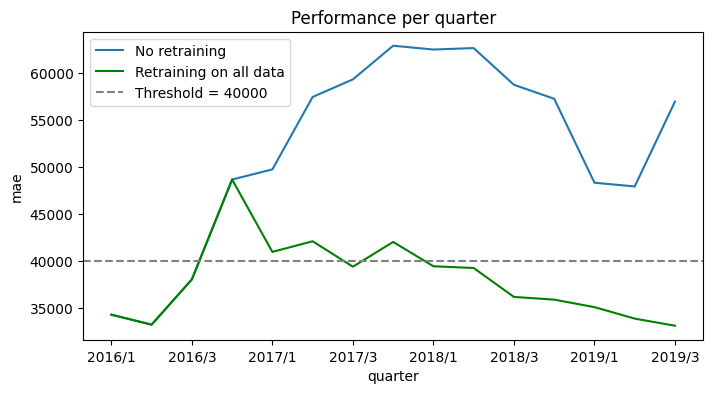

In [105]:
# Draw the figure
default_x_ticks = list(range(len(mae_no_retrain)))

# Values for x-axis
x_sticks = []
for year in data_folders:
    quarter_folders = sorted(os.listdir(WORKING_DIR/RAW_DATA_DIR/year))
    for q in quarter_folders:
        x_sticks.append(f"{year}/{q}")

plt.figure(figsize=(8, 4))
plt.plot(default_x_ticks, mae_no_retrain, label="No retraining")
plt.plot(default_x_ticks, mae_retrain_on_all, label="Retraining on all data", color="g")
plt.axhline(y=THRESHOLD, color='grey', linestyle = '--', label = f"Threshold = {THRESHOLD}")
plt.xlabel("quarter")
plt.ylabel("mae")
plt.xticks(default_x_ticks, x_sticks)
plt.locator_params(axis='x', nbins=8)
plt.title("Performance per quarter")
plt.legend(loc="upper left")
plt.show()

---
Please make sure you have the following files in your submission:
- This notebook (with up-to-date outputs of the code cells)
- prometheus-conf-patch.yaml
- A PDF containing the required screenshots of Assignments 1, 2 and 3. 